In [ ]:
import torch

# Configuration
noise_std = 0.001
torch.manual_seed(1)  # For reproducibility

# Generate clean x and y
def generate_clean_data(n_samples=100):
    x = torch.linspace(0, 1, n_samples).unsqueeze(1)
    x = (x - x.mean()) / x.std()
    y = 2 * x + noise_std * torch.randn_like(x)
    return x, y

# Generate and save
x, y = generate_clean_data()
torch.save({'x': x, 'y': y}, 'xy_values.pt')
print("Saved 'xy_values.pt' with x.shape =", x.shape, "and y.shape =", y.shape)

Saved 'xy_values.pt' with x.shape = torch.Size([100, 1]) and y.shape = torch.Size([100, 1])


k = 001 | Loss = 10.922173
k = 002 | Loss = 10.513045
k = 003 | Loss = 10.115984
k = 004 | Loss = 9.730599
k = 005 | Loss = 9.356957
k = 006 | Loss = 8.994553
k = 007 | Loss = 8.643158
k = 008 | Loss = 8.302505
k = 009 | Loss = 7.972545
k = 010 | Loss = 7.653059
k = 011 | Loss = 7.343555
k = 012 | Loss = 7.044001
k = 013 | Loss = 6.754111
k = 014 | Loss = 6.473886
k = 015 | Loss = 6.202706
k = 016 | Loss = 5.940553
k = 017 | Loss = 5.687049
k = 018 | Loss = 5.442067
k = 019 | Loss = 5.205658
k = 020 | Loss = 4.977352
k = 021 | Loss = 4.757075
k = 022 | Loss = 4.544483
k = 023 | Loss = 4.339348
k = 024 | Loss = 4.141734
k = 025 | Loss = 3.951321
k = 026 | Loss = 3.767753
k = 027 | Loss = 3.590761
k = 028 | Loss = 3.420463
k = 029 | Loss = 3.256749
k = 030 | Loss = 3.099218
k = 031 | Loss = 2.947746
k = 032 | Loss = 2.802244
k = 033 | Loss = 2.662676
k = 034 | Loss = 2.528486
k = 035 | Loss = 2.399722
k = 036 | Loss = 2.276114
k = 037 | Loss = 2.157682
k = 038 | Loss = 2.044167
k = 039 |

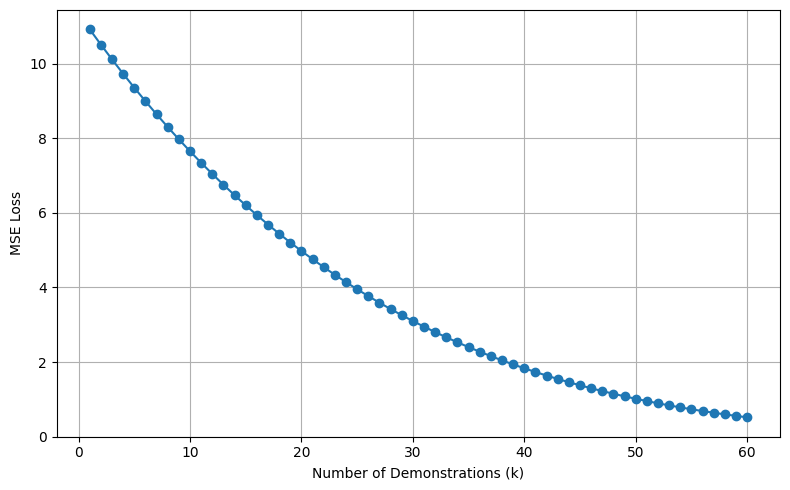

In [ ]:
import torch
import matplotlib.pyplot as plt

# --- Config ---
gamma = 0.2
β = 0.9
η = 0.001
N = 100
k_max = 60
noise_std = 0.001
torch.manual_seed(1)

# --- Fixed Attention Weights (4x4) ---
W_Q = torch.tensor([
    [1, 0, 0, 0],
    [gamma, -gamma, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=torch.float32)

W_K = torch.tensor([
    [0, 0, -η, 0],
    [0, 0, -η, 0],
    [0, 0, 0, -η],
    [1, -1, 0, 0]
], dtype=torch.float32)

W_V = torch.tensor([
    [0, 0, 1, 0],  # Only affects w_t1
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=torch.float32)

bias = torch.tensor([0, 0, -1, β], dtype=torch.float32)  # (4,)

# --- Load data ---
data = torch.load("xy_values.pt")
x_all, y_all = data["x"], data["y"]

# --- Evaluate with increasing number of demonstrations ---
losses = []

for k in range(1, k_max + 1):
    x_sup, y_sup = x_all[:k], y_all[:k]
    x_q, y_q = x_all[k:], y_all[k:]

    # Initial parameters
    w_t_demo = 1.0
    w_t1_demo = 2.0

    # --- Build h for support and query ---
    h_sup = torch.cat([
         torch.full_like(x_sup, w_t_demo),
        torch.full_like(x_sup, w_t1_demo),   # w_t1
        x_sup,                               # x
        y_sup                                # y
    ], dim=1)  # shape (k, 4)

    h_q = torch.cat([
        torch.full_like(x_q, w_t_demo),      # w_t
        torch.full_like(x_q, w_t1_demo),     # w_t1
        x_q,                                 # x
        torch.zeros_like(y_q)               # y = 0
    ], dim=1)  # shape (N-k, 4)

    # --- Attention ---
    Q = (h_q @ W_Q.T) + bias           # (N-k, 4)
    K = h_sup @ W_K.T                  # (k, 4)
    V = h_sup @ W_V.T                  # (k, 4)

    scores = Q @ K.T                   # (N-k, k)
    attn = scores / (K.shape[-1] ** 0.5)
    attn = attn / (attn.sum(dim=1, keepdim=True) + 1e-6)

    # --- NAG-style update: only h_q updated ---
    h_q_updated =  h_q +  (attn @ V)   # <--- KEY UPDATE LINE mimicking NAG
    h_q = h_q_updated
    # --- Prediction ---
    y_pred = h_q_updated[:, 0] * x_q.squeeze(1) + h_q_updated[:, 1]
    loss = ((y_pred - y_q.squeeze(1)) ** 2).mean()
    losses.append(loss.item())

    print(f"k = {k:03d} | Loss = {loss.item():.6f}")

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Number of Demonstrations (k)")
plt.ylabel("MSE Loss")
#plt.title("ICL Loss vs. Number of Demonstrations (NAG-style Update)")
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 0001 | Loss: 0.989937
Epoch 0002 | Loss: 0.982503
Epoch 0003 | Loss: 0.971975
Epoch 0004 | Loss: 0.958741
Epoch 0005 | Loss: 0.943162
Epoch 0006 | Loss: 0.925574
Epoch 0007 | Loss: 0.906286
Epoch 0008 | Loss: 0.885584
Epoch 0009 | Loss: 0.863725
Epoch 0010 | Loss: 0.840946
Epoch 0011 | Loss: 0.817459
Epoch 0012 | Loss: 0.793453
Epoch 0013 | Loss: 0.769099
Epoch 0014 | Loss: 0.744548
Epoch 0015 | Loss: 0.719933
Epoch 0016 | Loss: 0.695371
Epoch 0017 | Loss: 0.670965
Epoch 0018 | Loss: 0.646804
Epoch 0019 | Loss: 0.622963
Epoch 0020 | Loss: 0.599508
Epoch 0021 | Loss: 0.576493
Epoch 0022 | Loss: 0.553965
Epoch 0023 | Loss: 0.531961
Epoch 0024 | Loss: 0.510510
Epoch 0025 | Loss: 0.489638
Epoch 0026 | Loss: 0.469361
Epoch 0027 | Loss: 0.449692
Epoch 0028 | Loss: 0.430640
Epoch 0029 | Loss: 0.412208
Epoch 0030 | Loss: 0.394397
Epoch 0031 | Loss: 0.377206
Epoch 0032 | Loss: 0.360629
Epoch 0033 | Loss: 0.344660
Epoch 0034 | Loss: 0.329288
Epoch 0035 | Loss: 0.314505
Epoch 0036 | Loss: 0

<Figure size 1000x500 with 0 Axes>

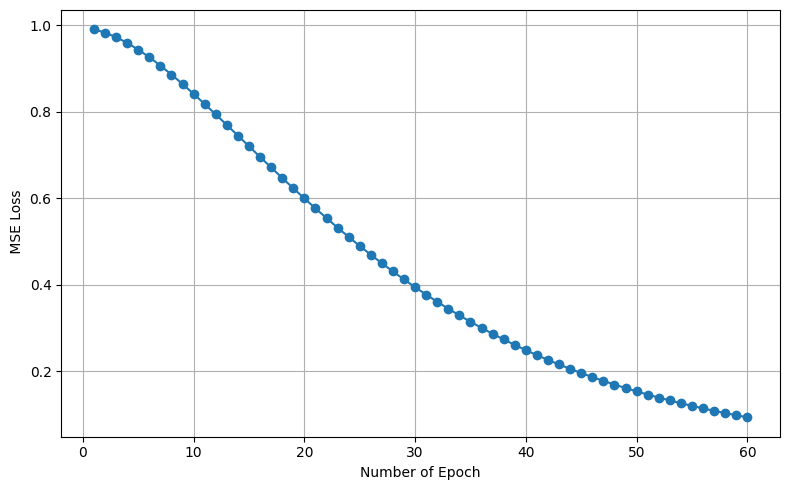

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ----- MLP Model with No Hidden Layers -----
class SimpleLinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, w_scalar=1.0):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self._init_weights(w_scalar)

    def forward(self, x):
        return self.linear(x)

    def _init_weights(self, w_scalar):
        with torch.no_grad():
            self.linear.weight.fill_(w_scalar)
            self.linear.bias.zero_()

# ----- Load Data from File -----
def load_data_from_file(file_path):
    data = torch.load(file_path)

    # If the file contains a tuple (x, y)
    if isinstance(data, tuple) and len(data) == 2:
        x, y = data
    # If the file contains a dict with keys 'x' and 'y'
    elif isinstance(data, dict) and 'x' in data and 'y' in data:
        x, y = data['x'], data['y']
    else:
        raise ValueError("Unexpected data format in file.")

    # Ensure x is 2D
    if x.dim() == 1:
        x = x.unsqueeze(1)
    if y.dim() == 1:
        y = y.unsqueeze(1)

    return x, y

# ----- Train and Plot -----
def train_and_visualize(model, x, y, lr=0.001, momentum=0.9, epochs=60, plot_interval=1):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
    mlosses = []

    plt.figure(figsize=(10, 5))
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)

        # Custom Squared Loss
        loss = ((y_pred - y) ** 2).mean()
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=0.1)
        loss.backward()
        optimizer.step()
        mlosses.append(loss.item())

        if (epoch + 1) % plot_interval == 0:
            print(f"Epoch {epoch+1:04d} | Loss: {loss.item():.6f}")

    # Plot
   #plt.plot(losses)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(mlosses) + 1), mlosses, marker='o')
    plt.xlabel("Number of Epoch")
    plt.ylabel(" MSE Loss")
    #plt.title("Training Loss with NAG + Scalar Weight Initialization")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return losses

# ----- Run Everything -----
if __name__ == "__main__":
    file_path = "xy_values.pt"
    x, y = load_data_from_file(file_path)
    model = SimpleLinearModel(input_dim=1, output_dim=1, w_scalar=1.0)
    losses = train_and_visualize(model, x, y)